In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
from scipy.integrate import quad_vec
import torch as tch

## Import de l'image et extraction des contours ##

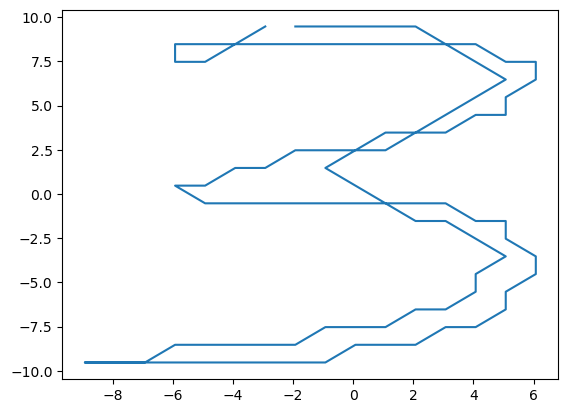

In [2]:
#Import de l'image et transformation en image binaire
img = cv2.imread("img_10.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255, 0)

#Extraction des contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

#Extraction des coordonées des points des contours et centrage de la figure
contours = np.array(contours[0]) 
x_list, y_list = contours[:, :, 0].reshape(-1,), -contours[:, :, 1].reshape(-1,)
x_list = x_list - np.mean(x_list)
y_list = y_list - np.mean(y_list)

#Affichage
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_list, y_list)

#Enregistre les limites de la figure 
xlim_data = plt.xlim() 
ylim_data = plt.ylim()
plt.show()



## Extraction des coefficients de fourier ##

In [70]:
tau = 2*np.pi
t_list = np.linspace(0, tau, len(x_list)) #liste allant de 0 à 2pi

#Expression des coordonnées sous formes complexe
def f(t, t_list, x_list, y_list):
    return np.interp(t, t_list, x_list + 1j*y_list)

#nombre de coefficients de fourier désiré
order = 50

#Calcul des coefficients de fourier
c = [] 
for n in range(-order, order+1):
    coef = 1/tau*quad_vec(lambda t: f(t, t_list, x_list, y_list)*np.exp(-n*t*1j), 0, tau, limit=100, full_output=1)[0]
    c.append(coef)

c = np.array(c)


## Dessin à partir des coefficients de fourier ##

In [4]:
#Classement des coefficients dans l'ordre
def sort_coeff(coeffs):
    new_coeffs = []
    new_coeffs.append(coeffs[order])
    for i in range(1, order+1):
        new_coeffs.extend([coeffs[order+i],coeffs[order-i]])
    return np.array(new_coeffs)

draw_x, draw_y = [], [] #integrer dans la fonction et à retourner si on veut juste obtenir la liste des coordonnées des points

def make_frame(i, time, coeffs):
    
    # extraction du temps
    t = time[i]

    # calcul du terme exponentielle permettant de faire tourner le cercle
    exp_term = np.array([np.exp(n*t*1j) for n in range(-order, order+1)])

    # classement des coefficients par ordre décroissant
    coeffs = sort_coeff(coeffs*exp_term) 

    # Extraction des infos sur x et y
    x_coeffs = np.real(coeffs)
    y_coeffs = np.imag(coeffs)

    # centre initial de la figure
    center_x, center_y = 0, 0
    
    # calcul la position du centre du cercle suivant
    for i, (x_coeff, y_coeff) in enumerate(zip(x_coeffs, y_coeffs)):
        center_x, center_y = center_x + x_coeff, center_y + y_coeff
    
    #à chaque instant t, le point est la position du dernier 'centre'
    draw_x.append(center_x)
    draw_y.append(center_y)

    # dessine la ligne entre les deux dernier points
    drawing.set_data(draw_x, draw_y)

drawing completed


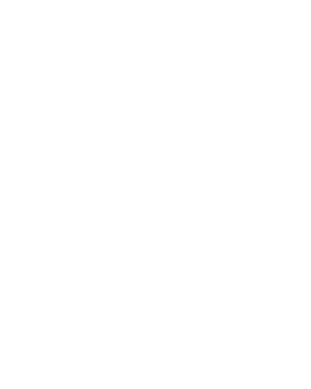

In [5]:
#Animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# make figure for animation
fig, ax = plt.subplots()

# drawing is plot of final drawing
drawing, = ax.plot([], [], 'k-', linewidth=2)

# to fix the size of figure so that the figure does not get cropped/trimmed
ax.set_xlim(xlim_data[0], xlim_data[1])
ax.set_ylim(ylim_data[0], ylim_data[1])

# hide axes
ax.set_axis_off()

# to have symmetric axes
ax.set_aspect('equal')

frames = 300
time = np.linspace(0, tau, num=frames)
anim = animation.FuncAnimation(fig, make_frame, frames=frames, fargs=(time, c),interval=5)
#save figure
#anim.save('epicycle_test2.mp4', writer=writer)
print("drawing completed")

## Extraction des coordonnées des points à partir des coefficients de Fourier ##

In [71]:
#Classement des coefficients dans l'ordre
def sort_coeff(coeffs):
    new_coeffs = []
    new_coeffs.append(coeffs[order])
    for i in range(1, order+1):
        new_coeffs.extend([coeffs[order+i],coeffs[order-i]])
    return np.array(new_coeffs)


new_list_x, new_list_y = [], []
def extract_coordo(i, time, coeffs):
    
    # extraction du temps
    t = time[i]

    # calcul du terme exponentielle permettant de faire tourner le cercle
    exp_term = np.array([np.exp(n*t*1j) for n in range(-order, order+1)])

    # classement des coefficients par ordre décroissant
    coeffs = sort_coeff(coeffs*exp_term) 

    # Extraction des infos sur x et y
    x_coeffs = np.real(coeffs)
    y_coeffs = np.imag(coeffs)

    # centre initial de la figure
    center_x, center_y = 0, 0
    
    # calcul la position du centre du cercle suivant
    for i, (x_coeff, y_coeff) in enumerate(zip(x_coeffs, y_coeffs)):
        center_x, center_y = center_x + x_coeff, center_y + y_coeff
    
    #à chaque instant t, le point est la position du dernier 'centre'
    new_list_x.append(center_x)
    new_list_y.append(center_y)
    


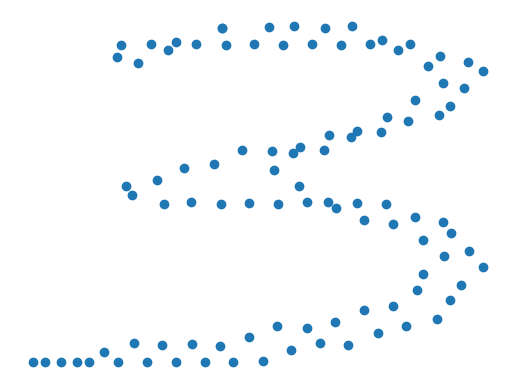

In [72]:
frames = 100 #nb d'échantillon
time = np.linspace(0, tau, num=frames) 

for i in range(frames):
    extract_coordo(i, time, c)
    
#Affichage simple des points
plt.scatter(new_list_x,new_list_y)
plt.axis('off')
plt.show()

## Draw lines & transform in image ##

### Methode 1 : Via MatplotLib

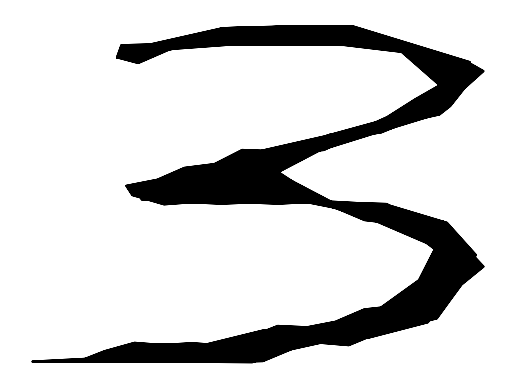

In [31]:
# Tracer les lignes reliant les points
plt.plot(new_list_x, new_list_y, color='black')

# Remplir les pixels situés à l'intérieur des lignes tracées
plt.fill(new_list_x, new_list_y, color='black')
plt.axis('off')

#Enregistrement de l'image
plt.savefig('image.png', format='png')

# Afficher l'image binaire
plt.show()


In [60]:
#On récupère l'image
img_reconstruite = cv2.imread("image.png")

#On resize
resized_image = cv2.resize(img_reconstruite, (28, 28))

#On rend binaire le masque
resized_image = resized_image/255
resized_image = (resized_image[:,:,0] + resized_image[:,:,1] + resized_image[:,:,2])/3

resized_image[resized_image >= 0.5] = 1
resized_image[resized_image < 0.5] = 0


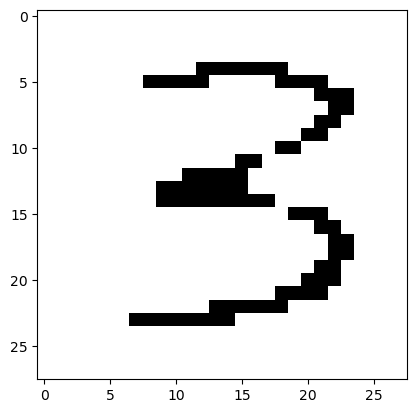

In [79]:
#Affichage du masque
plt.imshow(resized_image,cmap='gray')

### Methode 2 : avec noyau gaussien et pytorch ###

In [100]:
# Paramètres de la distribution gaussienne
ecart_type = 1

# Créer une grille de coordonnées X et Y
X, Y = tch.meshgrid(tch.linspace(xlim_data[0], xlim_data[1], 28), tch.linspace(ylim_data[0], ylim_data[1], 28), indexing ='xy')

# Créer une image vide
img_gaussienne = tch.zeros(28,28)

# Pour chaque point dans les listes new_list_x et new_list_y
for x, y in zip(new_list_x, new_list_y):
    # Calculer la gaussienne centrée en ce point
    gaussienne = tch.exp(-((X - x) ** 2 + (Y - y) ** 2) / (2 * ecart_type ** 2))
    # Puis les additionner dans une image
    img_gaussienne += gaussienne


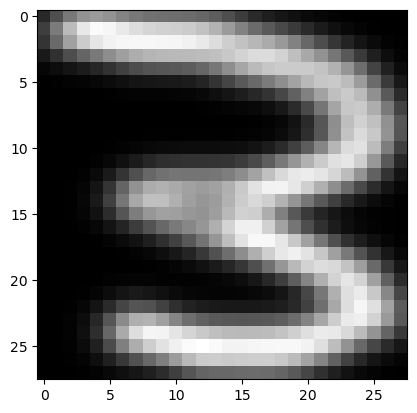

In [101]:
#Affichage de l'image
plt.imshow(img_gaussienne,cmap='gray')

In [102]:
img_gaussienne.shape

torch.Size([28, 28])

### Extract coef new method ###

In [8]:
from torch.fft import fft, fftshift

list_coordo_x = tch.tensor([2,2,2,2,2,2,2,2,2,3/2,1, 1/2,0,-1/2,-1,-3/2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-3/2, -1,-1/2, 0, 1/2, 1, 3/2])
list_coordo_y = tch.tensor([2, 3/2, 1, 1/2, 0, -1/2, -1, -3/2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -3/2, -1, -1/2, 0, 1/2, 1, 3/2, 2, 2, 2, 2, 2,2, 2, 2])

#Coordonnées des points en complexe
z_list = list_coordo_x + 1j * list_coordo_y

#Transformée de Fourier
f_z = fft(z_list)
f_z = fftshift(f_z)

#Indices des coefficients de fourier
N = tch.arange(-len(f_z)/2, len(f_z)/2)

#Extraction des phases
#Arg_fz = tch.angle(f_z).reshape(len(z_list),), 2*tch.pi

#Tri des phases par ordre decroissant
#sort_idx = tch.argsort(Arg_fz[0], descending = True)
#f_z = f_z[sort_idx]
#N = N[sort_idx]

#Echelle de temps
time2 = tch.linspace(0, 1, steps=100).reshape(100,1)

#Selection des indices
sub = tch.arange(0,len(z_list))
N_sub = N[sub].reshape(1,len(z_list))
N_sub = N_sub.to(tch.complex64)

#Matrice complexe contenant les termes de la transformée inverse de Fourier.
TN = tch.exp(1j * 2 * tch.pi * time2 @ N_sub)

#Reconstruction du signal
Z = TN @ (f_z[sub]/len(f_z))

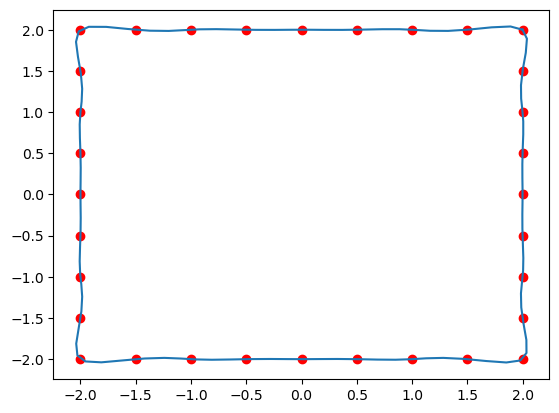

In [9]:
plt.scatter(list_coordo_x, list_coordo_y, color='red')
plt.plot(tch.real(Z),tch.imag(Z))

In [92]:
#Exemple avec image

#Coordonnées des points en complexe
x_list_tensor = tch.tensor(x_list)
y_list_tensor = tch.tensor(y_list)
z_list_2 = x_list_tensor + 1j * y_list_tensor

#Transformée de Fourier discrète
z_list_2 = z_list_2 #.reshape(len(z_list_2),1)
fz_2 = fft(z_list_2)
fz_2 = fftshift(fz_2)

#Indices des coefficients de fourier
N_2 = tch.arange(-len(fz_2)/2, len(fz_2)/2)

#Extraction de la phase des coordonnées exprimées en Fourier
#Arg_fz_2 = tch.angle(fz_2).reshape(len(z_list_2),), 2*tch.pi

#Tri des phases par ordre décroissant
#sort_idx_2 = tch.argsort(Arg_fz_2, descending = True)
#fz_2 = fz_2[sort_idx_2]
#N_2 = N_2[sort_idx_2]

#Sequence temporelle
time2 = tch.linspace(0, 1, steps=95).reshape(95,1)

#Selection des indices
sub2 = tch.arange(0,len(fz_2))
N_sub2 = N_2[sub2].reshape(1,len(fz_2))
N_sub2 = N_sub2.to(tch.complex64)


In [115]:
#Matrice transformée inverse de Fourier
TN2 = tch.exp(1j * 2 * tch.pi * time2 @ N_sub2)

In [116]:
#Reconstruction du signal 
Z2 = TN2.to(tch.complex128) @ (fz_2[sub2]/len(fz_2))

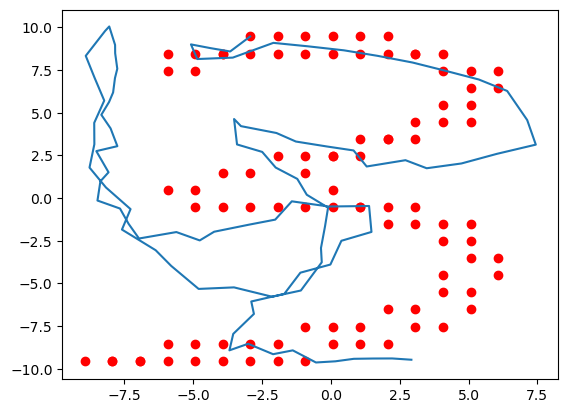

In [120]:
plt.plot(tch.real(Z2),tch.imag(Z2))
plt.scatter(x_list,y_list,color='red')